# Train ORCNN on amodal datasets

In [1]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os
import cv2
import random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog,MetadataCatalog
from detectron2.engine import DefaultTrainer
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10,10
def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    plt.show()
    
# run on gpu 0 (NVIDIA Geforce GTX 1080Ti) and gpu 1 (NVIDIA Geforce GTX 1070Ti)
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

## Register the amodal datasets 

In [2]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("broccoli_amodal_train", {}, "datasets/20201231_size_experiment_realsense/train/annotations.json", "datasets/20201231_size_experiment_realsense/train")
register_coco_instances("broccoli_amodal_val", {}, "datasets/20201231_size_experiment_realsense/val/annotations.json", "datasets/20201231_size_experiment_realsense/val")
register_coco_instances("broccoli_amodal_test", {}, "datasets/20201231_size_experiment_realsense/test/annotations.json", "datasets/20201231_size_experiment_realsense/test")

In [3]:
broccoli_amodal_train_metadata = MetadataCatalog.get("broccoli_amodal_train")
print(broccoli_amodal_train_metadata)

broccoli_amodal_val_metadata = MetadataCatalog.get("broccoli_amodal_val")
print(broccoli_amodal_val_metadata)

broccoli_amodal_test_metadata = MetadataCatalog.get("broccoli_amodal_test")
print(broccoli_amodal_test_metadata)

Metadata(evaluator_type='coco', image_root='datasets/20201231_size_experiment_realsense/train', json_file='datasets/20201231_size_experiment_realsense/train/annotations.json', name='broccoli_amodal_train')
Metadata(evaluator_type='coco', image_root='datasets/20201231_size_experiment_realsense/val', json_file='datasets/20201231_size_experiment_realsense/val/annotations.json', name='broccoli_amodal_val')
Metadata(evaluator_type='coco', image_root='datasets/20201231_size_experiment_realsense/test', json_file='datasets/20201231_size_experiment_realsense/test/annotations.json', name='broccoli_amodal_test')


In [4]:
dataset_dicts_train = DatasetCatalog.get("broccoli_amodal_train")
dataset_dicts_val = DatasetCatalog.get("broccoli_amodal_val")
dataset_dicts_test = DatasetCatalog.get("broccoli_amodal_test")

[09/09 17:15:05 d2.data.datasets.coco]: Loaded 1119 images in COCO format from datasets/20201231_size_experiment_realsense/train/annotations.json
[09/09 17:15:05 d2.data.datasets.coco]: Loaded 352 images in COCO format from datasets/20201231_size_experiment_realsense/val/annotations.json
[09/09 17:15:05 d2.data.datasets.coco]: Loaded 362 images in COCO format from datasets/20201231_size_experiment_realsense/test/annotations.json


## Visualize the amodal dataset 

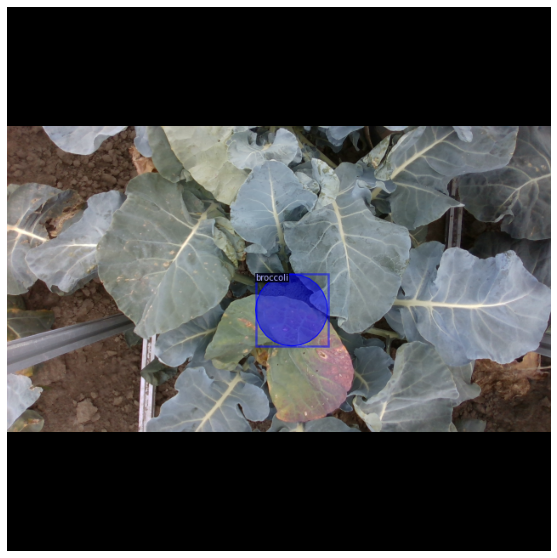

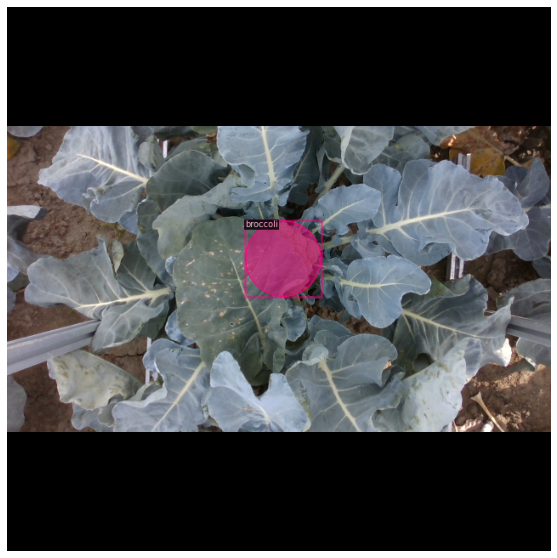

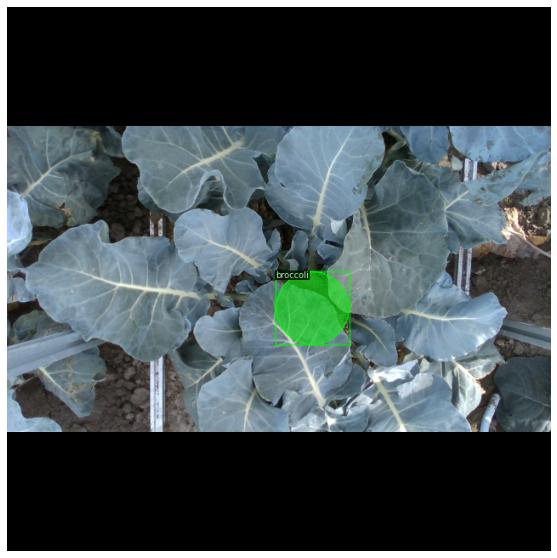

In [5]:
for d in random.sample(dataset_dicts_train, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=broccoli_amodal_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d, segm='segmentation')
    imshow(vis.get_image()[:, :, ::-1])

## Visualize the visible masks (modal dataset) 

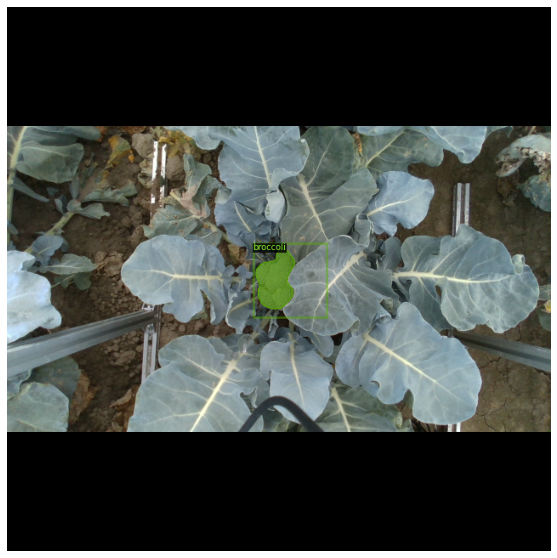

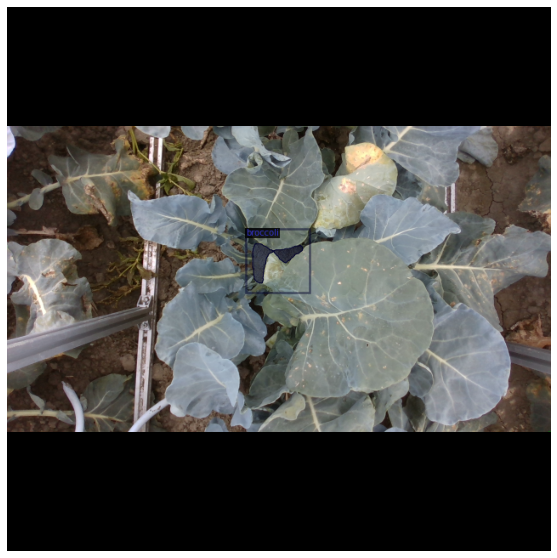

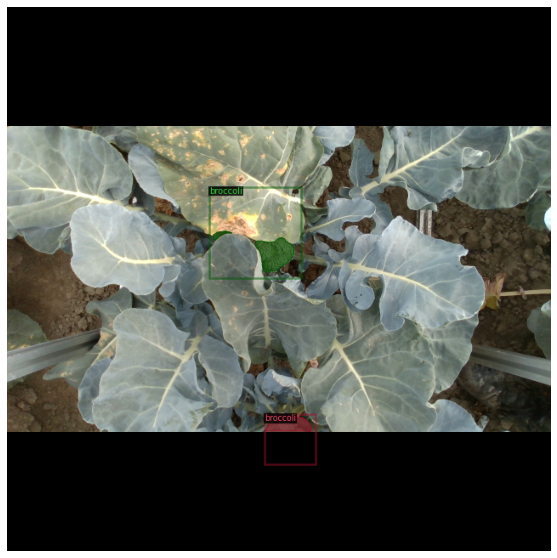

In [6]:
for d in random.sample(dataset_dicts_train, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=broccoli_amodal_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d, segm='visible_mask')
    imshow(vis.get_image()[:, :, ::-1])

## Initialize the training and inference parameters

In [7]:
# thanks to: https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
# thanks to: https://colab.research.google.com/drive/1-TNOcPm3Jr3fOJG8rnGT9gh60mHUsvaW#scrollTo=B4UESNQ4tyVm
# code extracted from: https://gist.github.com/ortegatron/c0dad15e49c2b74de8bb09a5615d9f6b

from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime
import logging

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

In [8]:
from detectron2.evaluation import AmodalEvaluator

class AmodalTrainer(DefaultTrainer):
    
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return AmodalEvaluator(dataset_name, cfg, False, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

In [9]:
import os
import numpy as np
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_orcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("broccoli_amodal_train",)
cfg.DATASETS.TEST = ("broccoli_amodal_val",)
cfg.TEST.EVAL_PERIOD = 1000

cfg.NUM_GPUS = 2
cfg.DATALOADER.NUM_WORKERS = 2
 # Let training initialize from the pretrained amodal-visible network
cfg.MODEL.WEIGHTS = os.path.join("weights/broccoli_amodal_visible", "model_final.pth")

# solver file settings extracted from: https://github.com/facebookresearch/Detectron/blob/master/configs/04_2018_gn_baselines/scratch_e2e_mask_rcnn_R-101-FPN_3x_gn.yaml
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.LR_POLICY = 'steps_with_decay'
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.GAMMA = 0.1
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 10000
cfg.SOLVER.STEPS = (5000, 9000, 9500)
cfg.SOLVER.CHECKPOINT_PERIOD = 1000

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (broccoli)

# https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
cfg.OUTPUT_DIR = "weights/broccoli_realsense"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = AmodalTrainer(cfg) 

[09/09 17:15:31 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[09/09 17:15:31 d2.data.datasets.coco]: Loaded 1119 images in COCO format from datasets/20201231_size_experiment_realsense/train/annotations.json
[09/09 17:15:31 d2.data.build]: Removed 0 images with no usable annotations. 1119 images left.
[09/09 17:15:31 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  broccoli  | 1357         |
|            |              |
[09/09 17:15:31 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[09/09 17:15:31 d2.data.build]: Using training sampler TrainingSampler
[09/09 17:15:31 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[09/09 17:15:31 d2.data.datasets.coco]: Loaded 352 images in COCO format from datasets/20201

## Start the training 

In [10]:
trainer.resume_or_load(resume=False)
trainer.train()

[09/09 17:15:34 d2.engine.train_loop]: Starting training from iteration 5000
[09/09 17:15:47 d2.utils.events]: eta: 0:52:57  iter: 5019  total_loss: 0.500  loss_cls: 0.054  loss_box_reg: 0.164  loss_amodal_mask: 0.187  loss_visible_mask: 0.063  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  time: 0.6297  data_time: 0.0080  lr: 0.000400  max_mem: 4514M
[09/09 17:16:00 d2.utils.events]: eta: 0:51:50  iter: 5039  total_loss: 0.409  loss_cls: 0.047  loss_box_reg: 0.132  loss_amodal_mask: 0.168  loss_visible_mask: 0.066  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  time: 0.6403  data_time: 0.0025  lr: 0.000799  max_mem: 4610M
[09/09 17:16:13 d2.utils.events]: eta: 0:52:02  iter: 5059  total_loss: 0.486  loss_cls: 0.043  loss_box_reg: 0.144  loss_amodal_mask: 0.210  loss_visible_mask: 0.060  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  time: 0.6385  data_time: 0.0025  lr: 0.001199  max_mem: 4610M
[09/09 17:16:26 d2.utils.events]: eta: 0:52:00  iter: 5079  total_loss: 0.378  loss_cls: 0.041  loss_box_re

[09/09 17:22:01 d2.utils.events]: eta: 0:47:10  iter: 5599  total_loss: 0.671  loss_cls: 0.085  loss_box_reg: 0.177  loss_amodal_mask: 0.202  loss_visible_mask: 0.143  loss_rpn_cls: 0.005  loss_rpn_loc: 0.003  time: 0.6433  data_time: 0.0021  lr: 0.011988  max_mem: 4792M
[09/09 17:22:14 d2.utils.events]: eta: 0:46:57  iter: 5619  total_loss: 0.700  loss_cls: 0.069  loss_box_reg: 0.196  loss_amodal_mask: 0.265  loss_visible_mask: 0.117  loss_rpn_cls: 0.002  loss_rpn_loc: 0.004  time: 0.6436  data_time: 0.0023  lr: 0.012388  max_mem: 4792M
[09/09 17:22:26 d2.utils.events]: eta: 0:46:44  iter: 5639  total_loss: 0.640  loss_cls: 0.080  loss_box_reg: 0.243  loss_amodal_mask: 0.221  loss_visible_mask: 0.076  loss_rpn_cls: 0.001  loss_rpn_loc: 0.005  time: 0.6433  data_time: 0.0024  lr: 0.012787  max_mem: 4792M
[09/09 17:22:39 d2.utils.events]: eta: 0:46:30  iter: 5659  total_loss: 0.505  loss_cls: 0.044  loss_box_reg: 0.161  loss_amodal_mask: 0.177  loss_visible_mask: 0.080  loss_rpn_cls: 0.

[09/09 17:27:13 d2.evaluation.AmodalCocoEvaluation]: Note that some metrics cannot be computed.
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.17s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.681
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.957
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.814
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.682
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.668
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.727
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= 

[09/09 17:30:21 d2.utils.events]: eta: 0:40:46  iter: 6219  total_loss: 0.567  loss_cls: 0.071  loss_box_reg: 0.176  loss_amodal_mask: 0.180  loss_visible_mask: 0.075  loss_rpn_cls: 0.002  loss_rpn_loc: 0.004  validation_loss: 0.536  time: 0.6464  data_time: 0.0024  lr: 0.020000  max_mem: 4792M
[09/09 17:30:34 d2.utils.events]: eta: 0:40:36  iter: 6239  total_loss: 0.614  loss_cls: 0.085  loss_box_reg: 0.212  loss_amodal_mask: 0.225  loss_visible_mask: 0.073  loss_rpn_cls: 0.001  loss_rpn_loc: 0.005  validation_loss: 0.536  time: 0.6468  data_time: 0.0025  lr: 0.020000  max_mem: 4792M
[09/09 17:30:47 d2.utils.events]: eta: 0:40:23  iter: 6259  total_loss: 0.446  loss_cls: 0.053  loss_box_reg: 0.160  loss_amodal_mask: 0.180  loss_visible_mask: 0.063  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  validation_loss: 0.536  time: 0.6466  data_time: 0.0025  lr: 0.020000  max_mem: 4792M
[09/09 17:31:00 d2.utils.events]: eta: 0:40:15  iter: 6279  total_loss: 0.459  loss_cls: 0.050  loss_box_reg: 0.

[09/09 17:36:10 d2.utils.events]: eta: 0:34:55  iter: 6759  total_loss: 0.570  loss_cls: 0.055  loss_box_reg: 0.175  loss_amodal_mask: 0.228  loss_visible_mask: 0.081  loss_rpn_cls: 0.002  loss_rpn_loc: 0.005  validation_loss: 0.536  time: 0.6462  data_time: 0.0021  lr: 0.020000  max_mem: 4792M
[09/09 17:36:22 d2.utils.events]: eta: 0:34:42  iter: 6779  total_loss: 0.535  loss_cls: 0.052  loss_box_reg: 0.170  loss_amodal_mask: 0.214  loss_visible_mask: 0.067  loss_rpn_cls: 0.002  loss_rpn_loc: 0.006  validation_loss: 0.536  time: 0.6461  data_time: 0.0021  lr: 0.020000  max_mem: 4792M
[09/09 17:36:35 d2.utils.events]: eta: 0:34:27  iter: 6799  total_loss: 0.441  loss_cls: 0.045  loss_box_reg: 0.148  loss_amodal_mask: 0.159  loss_visible_mask: 0.052  loss_rpn_cls: 0.001  loss_rpn_loc: 0.004  validation_loss: 0.536  time: 0.6460  data_time: 0.0027  lr: 0.020000  max_mem: 4792M
[09/09 17:36:48 d2.utils.events]: eta: 0:34:14  iter: 6819  total_loss: 0.406  loss_cls: 0.051  loss_box_reg: 0.

[09/09 17:39:33 d2.evaluation.AmodalCocoEvaluation]: Note that some metrics cannot be computed.
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *visible*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.795
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.985
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.915
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.795
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.770
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.844
 Average Recall     (AR) @[ IoU=0.50:0.95 | are

[09/09 17:43:41 d2.utils.events]: eta: 0:28:42  iter: 7319  total_loss: 0.510  loss_cls: 0.054  loss_box_reg: 0.168  loss_amodal_mask: 0.176  loss_visible_mask: 0.058  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  validation_loss: 0.490  time: 0.6456  data_time: 0.0024  lr: 0.020000  max_mem: 4792M
[09/09 17:43:55 d2.utils.events]: eta: 0:28:28  iter: 7339  total_loss: 0.451  loss_cls: 0.063  loss_box_reg: 0.166  loss_amodal_mask: 0.169  loss_visible_mask: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.005  validation_loss: 0.490  time: 0.6457  data_time: 0.0024  lr: 0.020000  max_mem: 4792M
[09/09 17:44:08 d2.utils.events]: eta: 0:28:17  iter: 7359  total_loss: 0.454  loss_cls: 0.041  loss_box_reg: 0.168  loss_amodal_mask: 0.161  loss_visible_mask: 0.053  loss_rpn_cls: 0.001  loss_rpn_loc: 0.004  validation_loss: 0.490  time: 0.6458  data_time: 0.0024  lr: 0.020000  max_mem: 4792M
[09/09 17:44:21 d2.utils.events]: eta: 0:28:07  iter: 7379  total_loss: 0.533  loss_cls: 0.058  loss_box_reg: 0.

[09/09 17:49:33 d2.utils.events]: eta: 0:23:01  iter: 7859  total_loss: 0.515  loss_cls: 0.066  loss_box_reg: 0.175  loss_amodal_mask: 0.194  loss_visible_mask: 0.063  loss_rpn_cls: 0.001  loss_rpn_loc: 0.005  validation_loss: 0.490  time: 0.6464  data_time: 0.0023  lr: 0.020000  max_mem: 4792M
[09/09 17:49:46 d2.utils.events]: eta: 0:22:49  iter: 7879  total_loss: 0.462  loss_cls: 0.052  loss_box_reg: 0.182  loss_amodal_mask: 0.161  loss_visible_mask: 0.050  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  validation_loss: 0.490  time: 0.6464  data_time: 0.0024  lr: 0.020000  max_mem: 4792M
[09/09 17:49:59 d2.utils.events]: eta: 0:22:38  iter: 7899  total_loss: 0.426  loss_cls: 0.034  loss_box_reg: 0.139  loss_amodal_mask: 0.142  loss_visible_mask: 0.050  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  validation_loss: 0.490  time: 0.6465  data_time: 0.0023  lr: 0.020000  max_mem: 4792M
[09/09 17:50:12 d2.utils.events]: eta: 0:22:26  iter: 7919  total_loss: 0.471  loss_cls: 0.046  loss_box_reg: 0.

[09/09 17:51:54 d2.evaluation.AmodalCocoEvaluation]: Note that some metrics cannot be computed.
[09/09 17:51:54 d2.engine.defaults]: Evaluation results for broccoli_amodal_val in csv format:
[09/09 17:51:54 d2.evaluation.testing]: copypaste: Task: bbox
[09/09 17:51:54 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/09 17:51:54 d2.evaluation.testing]: copypaste: 55.0463,93.6560,60.6951,nan,nan,55.3397
[09/09 17:51:54 d2.evaluation.testing]: copypaste: Task: segm
[09/09 17:51:54 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/09 17:51:54 d2.evaluation.testing]: copypaste: 61.6259,93.1270,65.8616,nan,nan,62.2206
[09/09 17:51:54 d2.evaluation.testing]: copypaste: Task: visible
[09/09 17:51:54 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/09 17:51:54 d2.evaluation.testing]: copypaste: 82.7664,98.5305,93.9521,nan,nan,82.8564
[09/09 17:51:55 detectron2]: Loss on Validation  done 11/352. 0.0000 s / img. ETA=0:00:36
[09/09 17:52:00 detectron2]: 

[09/09 17:57:10 d2.utils.events]: eta: 0:17:08  iter: 8419  total_loss: 0.432  loss_cls: 0.044  loss_box_reg: 0.147  loss_amodal_mask: 0.173  loss_visible_mask: 0.050  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  validation_loss: 0.447  time: 0.6471  data_time: 0.0023  lr: 0.020000  max_mem: 4792M
[09/09 17:57:23 d2.utils.events]: eta: 0:16:56  iter: 8439  total_loss: 0.405  loss_cls: 0.042  loss_box_reg: 0.105  loss_amodal_mask: 0.148  loss_visible_mask: 0.056  loss_rpn_cls: 0.003  loss_rpn_loc: 0.003  validation_loss: 0.447  time: 0.6471  data_time: 0.0024  lr: 0.020000  max_mem: 4792M
[09/09 17:57:36 d2.utils.events]: eta: 0:16:41  iter: 8459  total_loss: 0.348  loss_cls: 0.035  loss_box_reg: 0.120  loss_amodal_mask: 0.119  loss_visible_mask: 0.051  loss_rpn_cls: 0.001  loss_rpn_loc: 0.003  validation_loss: 0.447  time: 0.6471  data_time: 0.0024  lr: 0.020000  max_mem: 4792M
[09/09 17:57:50 d2.utils.events]: eta: 0:16:29  iter: 8479  total_loss: 0.359  loss_cls: 0.043  loss_box_reg: 0.

[09/09 18:02:58 d2.utils.events]: eta: 0:11:12  iter: 8959  total_loss: 0.389  loss_cls: 0.049  loss_box_reg: 0.120  loss_amodal_mask: 0.135  loss_visible_mask: 0.049  loss_rpn_cls: 0.002  loss_rpn_loc: 0.004  validation_loss: 0.447  time: 0.6465  data_time: 0.0025  lr: 0.020000  max_mem: 4843M
[09/09 18:03:11 d2.utils.events]: eta: 0:10:58  iter: 8979  total_loss: 0.351  loss_cls: 0.033  loss_box_reg: 0.125  loss_amodal_mask: 0.135  loss_visible_mask: 0.042  loss_rpn_cls: 0.001  loss_rpn_loc: 0.004  validation_loss: 0.447  time: 0.6465  data_time: 0.0026  lr: 0.020000  max_mem: 4843M
[09/09 18:03:24 d2.data.datasets.coco]: Loaded 352 images in COCO format from datasets/20201231_size_experiment_realsense/val/annotations.json
[09/09 18:03:24 d2.evaluation.evaluator]: Start inference on 352 images
[09/09 18:03:26 d2.evaluation.evaluator]: Inference done 11/352. 0.1134 s / img. ETA=0:00:42
[09/09 18:03:31 d2.evaluation.evaluator]: Inference done 51/352. 0.1137 s / img. ETA=0:00:38
[09/09 

[09/09 18:04:32 detectron2]: Loss on Validation  done 176/352. 0.0000 s / img. ETA=0:00:21
[09/09 18:04:37 detectron2]: Loss on Validation  done 214/352. 0.0000 s / img. ETA=0:00:17
[09/09 18:04:42 detectron2]: Loss on Validation  done 257/352. 0.0000 s / img. ETA=0:00:11
[09/09 18:04:47 detectron2]: Loss on Validation  done 299/352. 0.0000 s / img. ETA=0:00:06
[09/09 18:04:52 detectron2]: Loss on Validation  done 340/352. 0.0000 s / img. ETA=0:00:01
[09/09 18:04:54 d2.utils.events]: eta: 0:10:46  iter: 8999  total_loss: 0.345  loss_cls: 0.034  loss_box_reg: 0.124  loss_amodal_mask: 0.133  loss_visible_mask: 0.048  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  validation_loss: 0.445  time: 0.6464  data_time: 0.0025  lr: 0.020000  max_mem: 4843M
[09/09 18:05:06 d2.utils.events]: eta: 0:10:32  iter: 9019  total_loss: 0.293  loss_cls: 0.027  loss_box_reg: 0.107  loss_amodal_mask: 0.103  loss_visible_mask: 0.052  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  validation_loss: 0.445  time: 0.6462  d

[09/09 18:10:30 d2.utils.events]: eta: 0:05:10  iter: 9519  total_loss: 0.371  loss_cls: 0.042  loss_box_reg: 0.136  loss_amodal_mask: 0.127  loss_visible_mask: 0.048  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  validation_loss: 0.445  time: 0.6464  data_time: 0.0026  lr: 0.020000  max_mem: 4843M
[09/09 18:10:43 d2.utils.events]: eta: 0:04:57  iter: 9539  total_loss: 0.423  loss_cls: 0.058  loss_box_reg: 0.133  loss_amodal_mask: 0.171  loss_visible_mask: 0.049  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  validation_loss: 0.445  time: 0.6463  data_time: 0.0026  lr: 0.020000  max_mem: 4843M
[09/09 18:10:56 d2.utils.events]: eta: 0:04:44  iter: 9559  total_loss: 0.361  loss_cls: 0.028  loss_box_reg: 0.119  loss_amodal_mask: 0.129  loss_visible_mask: 0.051  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  validation_loss: 0.445  time: 0.6463  data_time: 0.0025  lr: 0.020000  max_mem: 4843M
[09/09 18:11:08 d2.utils.events]: eta: 0:04:30  iter: 9579  total_loss: 0.355  loss_cls: 0.044  loss_box_reg: 0.

[09/09 18:16:17 d2.evaluation.evaluator]: Inference done 292/352. 0.1121 s / img. ETA=0:00:07
[09/09 18:16:22 d2.evaluation.evaluator]: Inference done 333/352. 0.1121 s / img. ETA=0:00:02
[09/09 18:16:25 d2.evaluation.evaluator]: Total inference time: 0:00:43.662170 (0.125828 s / img per device, on 1 devices)
[09/09 18:16:25 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:38 (0.112030 s / img per device, on 1 devices)
[09/09 18:16:25 d2.evaluation.AmodalCocoEvaluation]: Preparing results for COCO format ...
[09/09 18:16:25 d2.evaluation.AmodalCocoEvaluation]: Saving results to weights/broccoli_realsense/inference/coco_instances_results.json
[09/09 18:16:25 d2.evaluation.AmodalCocoEvaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95

## Visualize the training process in tensorboard

In [16]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir /home/pieterdeeplearn/harvestcnn/weights/broccoli_realsense

## Evaluation

In [11]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("broccoli_amodal_test",)
predictor = DefaultPredictor(cfg)

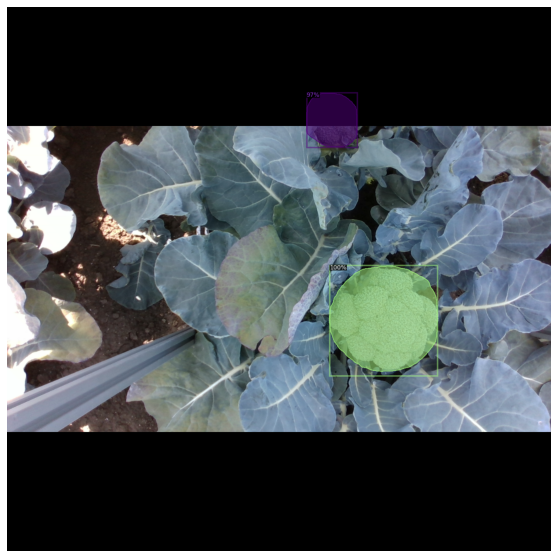

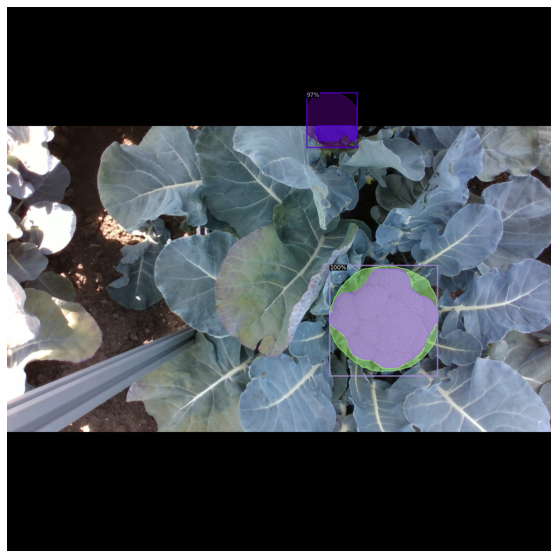

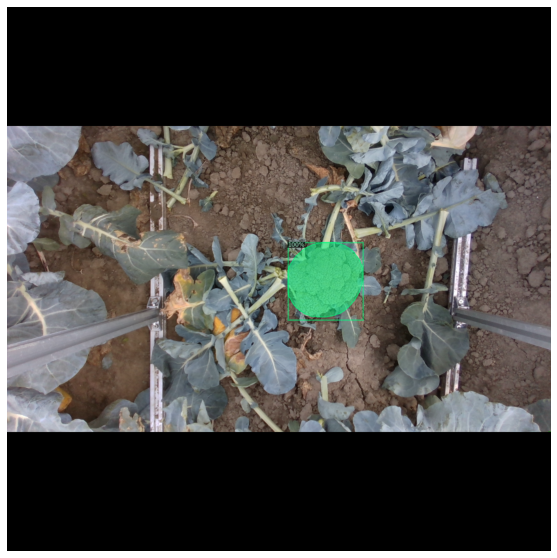

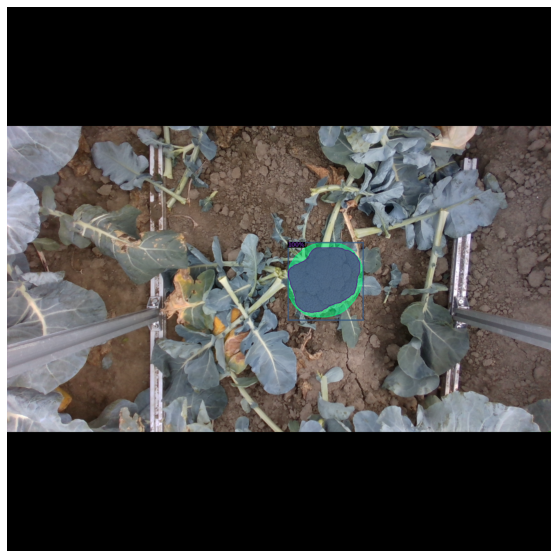

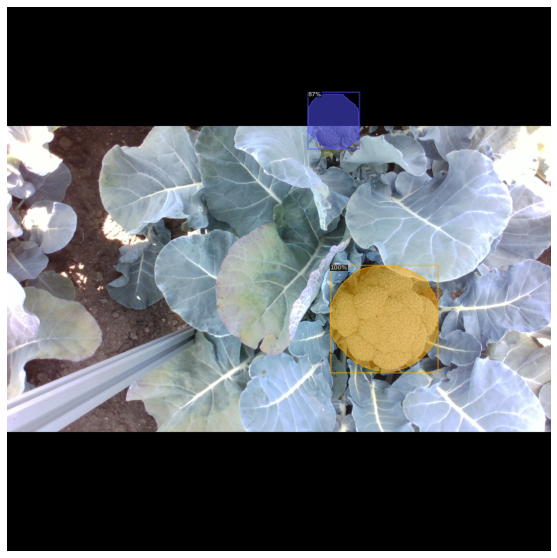

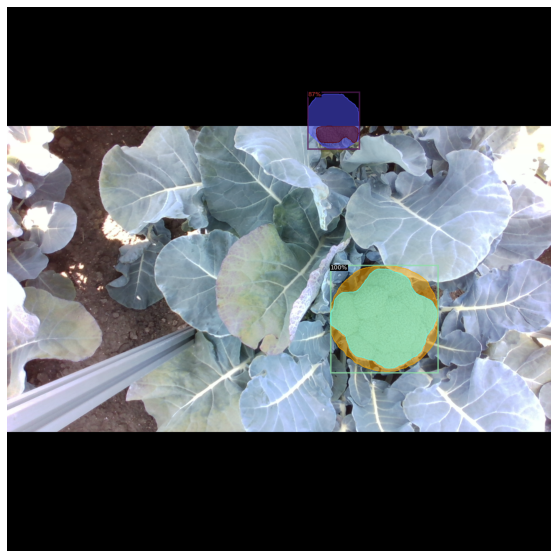

In [12]:
for d in random.sample(dataset_dicts_test, 3):       
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    visualizer = Visualizer(img[:, :, ::-1], metadata=broccoli_amodal_test_metadata, scale=0.8)
    amodal_mask = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    imshow(amodal_mask.get_image()[:, :, ::-1])
    modal_mask = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"), 'pred_visible_masks')
    imshow(modal_mask.get_image()[:, :, ::-1])

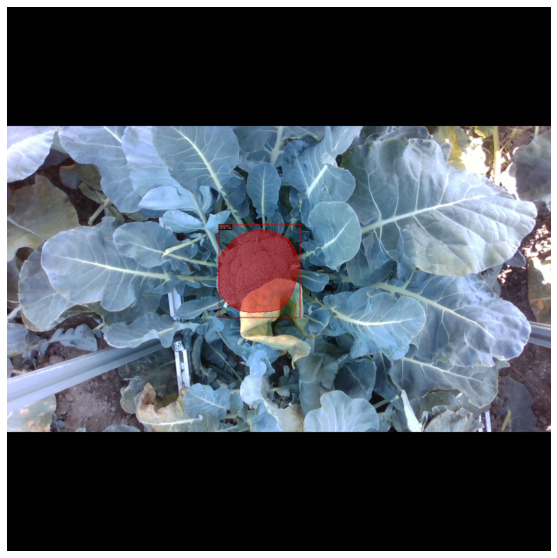

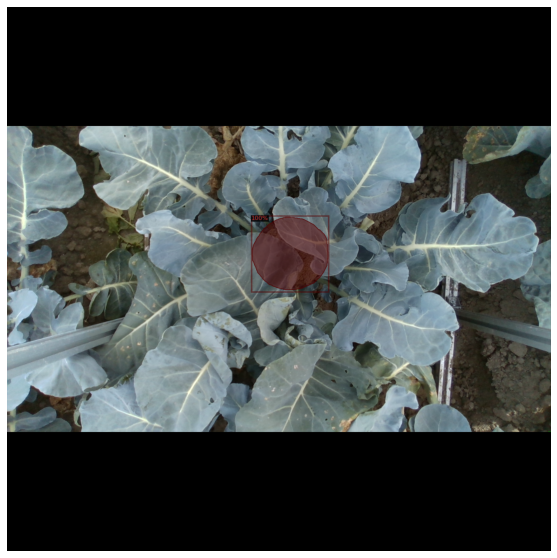

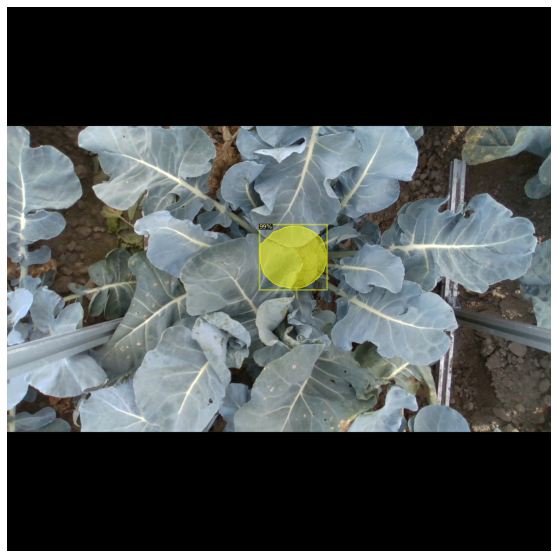

In [13]:
for d in random.sample(dataset_dicts_test, 3):       
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    visualizer = Visualizer(img[:, :, ::-1], metadata=broccoli_amodal_test_metadata, scale=0.8)
    vis = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    imshow(vis.get_image()[:, :, ::-1])

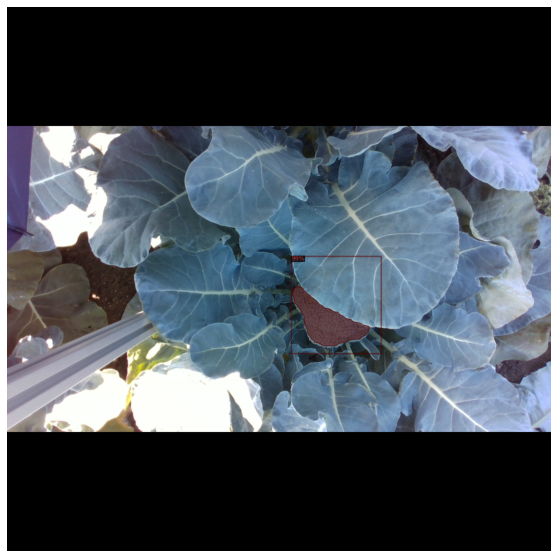

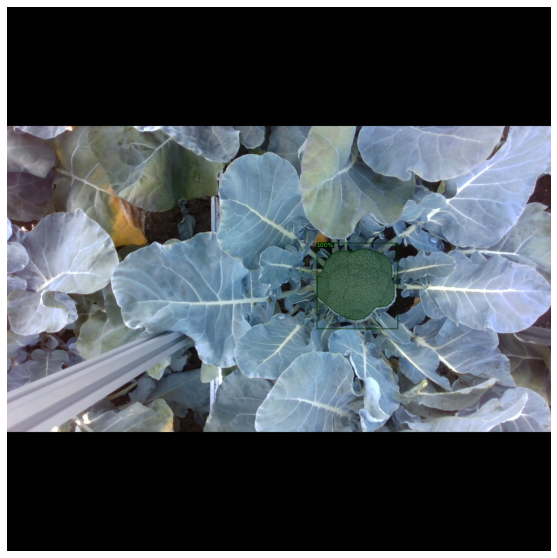

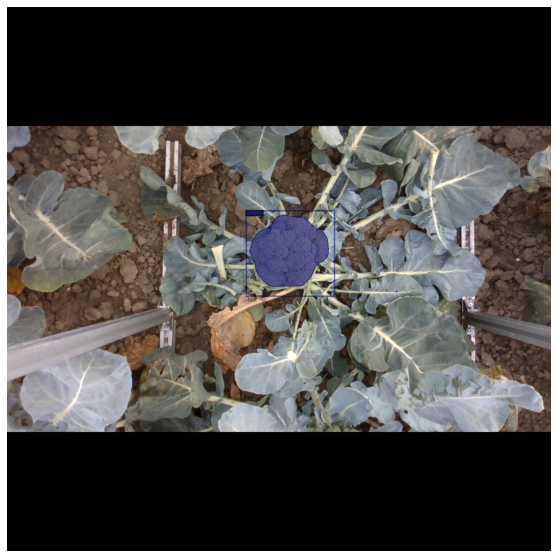

In [14]:
for d in random.sample(dataset_dicts_test, 3):       
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    visualizer = Visualizer(img[:, :, ::-1], metadata=broccoli_amodal_test_metadata, scale=0.8)
    vis = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"), 'pred_visible_masks')
    imshow(vis.get_image()[:, :, ::-1])

In [15]:
#  evaluate its performance using AP metric implemented in COCO API.
from detectron2.evaluation import AmodalEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = AmodalEvaluator("broccoli_amodal_test", cfg, False, output_dir="/home/pieterdeeplearn/ORCNN/Results/broccoli_amodal_visible")
val_loader = build_detection_test_loader(cfg, "broccoli_amodal_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

[09/09 19:45:31 d2.data.datasets.coco]: Loaded 362 images in COCO format from datasets/20201231_size_experiment_realsense/test/annotations.json
[09/09 19:45:31 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  broccoli  | 457          |
|            |              |
[09/09 19:45:31 d2.evaluation.evaluator]: Start inference on 362 images
[09/09 19:45:33 d2.evaluation.evaluator]: Inference done 11/362. 0.1107 s / img. ETA=0:00:45
[09/09 19:45:38 d2.evaluation.evaluator]: Inference done 50/362. 0.1108 s / img. ETA=0:00:40
[09/09 19:45:43 d2.evaluation.evaluator]: Inference done 89/362. 0.1109 s / img. ETA=0:00:35
[09/09 19:45:48 d2.evaluation.evaluator]: Inference done 129/362. 0.1107 s / img. ETA=0:00:30
[09/09 19:45:53 d2.evaluation.evaluator]: Inference done 169/362. 0.1106 s / img. ETA=0:00:24
[09/09 19:45:58 d2.evaluation.evaluator]: Inference done 209/362. 0.1106 s / img. ETA=0:00:19
[09/09 19:46:03 d2.ev

OrderedDict([('bbox',
              {'AP': 68.35200982021979,
               'AP50': 95.4169854311925,
               'AP75': 77.3397355907931,
               'APs': nan,
               'APm': 48.05162245144308,
               'APl': 68.7670084939592}),
             ('segm',
              {'AP': 68.63376850139666,
               'AP50': 95.31916586409397,
               'AP75': 77.8467824153922,
               'APs': nan,
               'APm': 40.02755142206906,
               'APl': 69.24611527138069}),
             ('visible',
              {'AP': 79.76921712109298,
               'AP50': 97.55145386535881,
               'AP75': 90.59338298752185,
               'APs': nan,
               'APm': 70.99946373615181,
               'APl': 79.91615749686962})])